In [1]:
import time
start_time = time.time()

In [2]:
patient_number       = "demo"
N                    = 250
nIter                = 300
criterion_bo         = "EI"

In [3]:
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [4]:
%cd ./PurkinjeECG

/media/pipe/hdd/Pipe/Proyectos_FS/Codes/purkinje-learning-demo/PurkinjeECG


### Reference tree

In [5]:
# As a reference, load best result found with Bayesian opt. with respect to real patient
var_parameters_read = ["init_length", "fascicles_length", "fascicles_angles",
                       "root_time", "cv"]

print ("Reading results of patient 1 ...")
if patient_number == "demo":
    X_read = np.load("./output/patient1/data_X_N_"+str(250)+
                "_nIter_"+str(300)+"_criterion"+str(criterion_bo)+"_"+
                "_".join(var_parameters_read)+".npy")

    y_read = np.load("./output/patient1/data_y_N_"+str(250)+
                "_nIter_"+str(300)+"_criterion"+str(criterion_bo)+"_"+
                "_".join(var_parameters_read)+".npy")
    
    X_min = X_read[np.argmin(y_read)]
    y_min = np.min(y_read)
    

var_params_true = {"init_length"     : [X_min[0], X_min[1]],
                   "fascicles_length": [[X_min[2], X_min[3]],
                                        [X_min[4], X_min[5]]],
                   "fascicles_angles": [[X_min[6], X_min[7]],
                                        [X_min[8], X_min[9]]],
                   "root_time"       : X_min[10],
                   "cv"              : X_min[11]}

true_x = list(var_params_true.values())

Reading results of patient 1 ...


In [6]:
dim = 2
def var_parameters_dict(var_parameters_names):
    var_parameters = {}
    
    # init_length
    if "init_length" in var_parameters_names:
        lb_init_length  = 30.0 * np.ones(dim) # 5
        ub_init_length  = 100.0 * np.ones(dim) # 55
        var_parameters["init_length"] = [lb_init_length, ub_init_length, "uniform"]
        # true_x += [30, 36.44783584]

    # length
    if "length" in var_parameters_names:
        lb_length = 4. * np.ones(1)
        ub_length = 12. * np.ones(1)
        var_parameters["length"] = [lb_length, ub_length, "uniform"]
        # true_x += [length, length]

    # w
    if "w" in var_parameters_names:
        lb_w = 0.05* np.ones(1) # 0.05
        ub_w = 0.25 * np.ones(1) # 0.8
        var_parameters["w"] = [lb_w, ub_w, "uniform"]
        # true_x += [w, w]

    # l_segment
    if "l_segment" in var_parameters_names:
        lb_l_segment = 1. * np.ones(dim)
        ub_l_segment = 15. * np.ones(dim)
        var_parameters["l_segment"] = [lb_l_segment, ub_l_segment, "uniform"]
        # true_x += [l_segment, l_segment]

    # fascicles_length
    if "fascicles_length" in var_parameters_names:
        lb_fascicles_length = 2.0 * np.ones(2*dim) # 10 # 2.*dim because there are 2 params per ventricle 
        ub_fascicles_length = 50.0 * np.ones(2*dim) # 30
        var_parameters["fascicles_length"] = [lb_fascicles_length, ub_fascicles_length, "uniform"]
        # true_x += 2 * f_len

    # f_angles
    if "fascicles_angles" in var_parameters_names:
        lb_fascicles_angles = -1./4. * onp.pi * np.ones(2*dim) # 0.1 # 2.*dim because there are 2 params per ventricle 
        ub_fascicles_angles = 3./4. * onp.pi * np.ones(2*dim) # 1.57
        var_parameters["fascicles_angles"] = [lb_fascicles_angles, ub_fascicles_angles, "uniform"]
        # true_x += 2 * f_angles

    # branch_angle
    if "branch_angle" in var_parameters_names:
        lb_branch_angle  = 5. * onp.pi/180. * np.ones(1)
        ub_branch_angle  = 45. * onp.pi/180. * np.ones(1)
        var_parameters["branch_angle"] = [lb_branch_angle, ub_branch_angle, "uniform"]
        # true_x += [branch_angle, branch_angle]
    
    # root_time
    if "root_time" in var_parameters_names:
        lb_root_time  = -75. * np.ones(1)
        ub_root_time  = 50. * np.ones(1)
        var_parameters["root_time"] = [lb_root_time, ub_root_time, "uniform"]
        
    # cv
    if "cv" in var_parameters_names:
        lb_cv  = 2. * np.ones(1)
        ub_cv  = 4. * np.ones(1)
        var_parameters["cv"] = [lb_cv, ub_cv, "uniform"]
        
    return var_parameters

In [7]:
var_parameters_list = ["init_length", "fascicles_length", "fascicles_angles","root_time", "cv"]
var_parameters      = var_parameters_dict(var_parameters_list)

### Plot results

#### Plot ecgs with mean and min/max

In [8]:
# Load results
ecg_true             = pickle.load(open(f"./output/patient{patient_number}/True_ecg", "rb"))
qrs_in, qrs_fin      = 0, len (ecg_true) # in this case we will use the full ecgs
ecg_pat_array        = ecg_true[qrs_in:qrs_fin]
                            
list_variable_params = "_".join(list(var_parameters.keys()))
file_name            = f"./output/patient{patient_number}/BO_N{N}_nIter{nIter}_criterion{criterion_bo}_variableparams_{list_variable_params}" 

name_ecg             = f"./output/patient{patient_number}/ecg_N{N}_nIter{nIter}_criterion{criterion_bo}_variableparams_{list_variable_params}"
ecg_final            = pickle.load(open(name_ecg, "rb"))

samples_final        = np.load(f"./output/patient{patient_number}/X_final_N{N}_nIter{nIter}_criterion{criterion_bo}_variableparams_{list_variable_params}.npy")

In [9]:
# Plot the ecgs of all possible trees
len1                  = ecg_pat_array.shape[0]
n_candidates_selected = len(samples_final)

selection_ecg = []
for ecg_fin_i,ind_fin_i in ecg_final:
    # selection of qrs complex of predicted ecgs
    selection_ecg.append(ecg_fin_i[ind_fin_i:ind_fin_i+len1])

In [10]:
# Find y limits
fig,axs = plt.subplots(2, 6, sharex = True, sharey = 'row')
for ax,l in zip(axs.ravel(), ('E1', 'E2', 'E3', 'aVR', 'aVL', 'aVF','V1', 'V2', 'V3', 'V4', 'V5', 'V6')): # bo_method.ground_truth.dtype.names
    ax.plot(ecg_true[l][0:250], 'tab:blue', alpha=0.6, label = "Ground truth")
    
    n_sel  = len(selection_ecg)
    n_time = len(selection_ecg[0])
    
    ecg_l = onp.empty((n_sel, n_time))
    for ind in onp.arange(n_sel):
        # # plot all ecgs
        # ax.plot(selection_ecg[ind][l],'r', alpha=0.6)
        ecg_l[ind, :] = selection_ecg[ind][l]
    
    mean_l = np.mean(ecg_l, axis=0)
#     std_l  = np.std(ecg_l, axis=0)
    min_l  = np.min(ecg_l, axis=0)
    max_l  = np.max(ecg_l, axis=0)
        
    label_BO = "BO (" + str(n_candidates_selected) + " trees)"

    ax.plot(qrs_in + np.arange(len(mean_l)), mean_l, 'r', alpha = 0.6, label = label_BO)
    ax.fill_between(qrs_in + np.arange(len(min_l)), min_l, max_l, color='r', alpha=.3)

    ax.grid(linestyle='--',alpha=0.4)
    ax.set_title(l)
    if l == "V4":
        ax.legend(fontsize="8")

# Calculate normalized heights based on y-limits
heights = []
for row_i in onp.arange(2):
    ax = axs[row_i, 0]
    heights += [ax.get_ylim()[1] - ax.get_ylim()[0]]

plt.close()

In [11]:
import matplotlib
import matplotlib.font_manager as fm

fm.fontManager.addfont('../Helvetica Neue Bold.ttf')
matplotlib.rc('font', family = 'Helvetica Neue')

plt.rcParams['font.family']      = u'Helvetica Neue'

plt.rcParams['font.size']        = 18
plt.rcParams['font.weight']      = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']   = 18

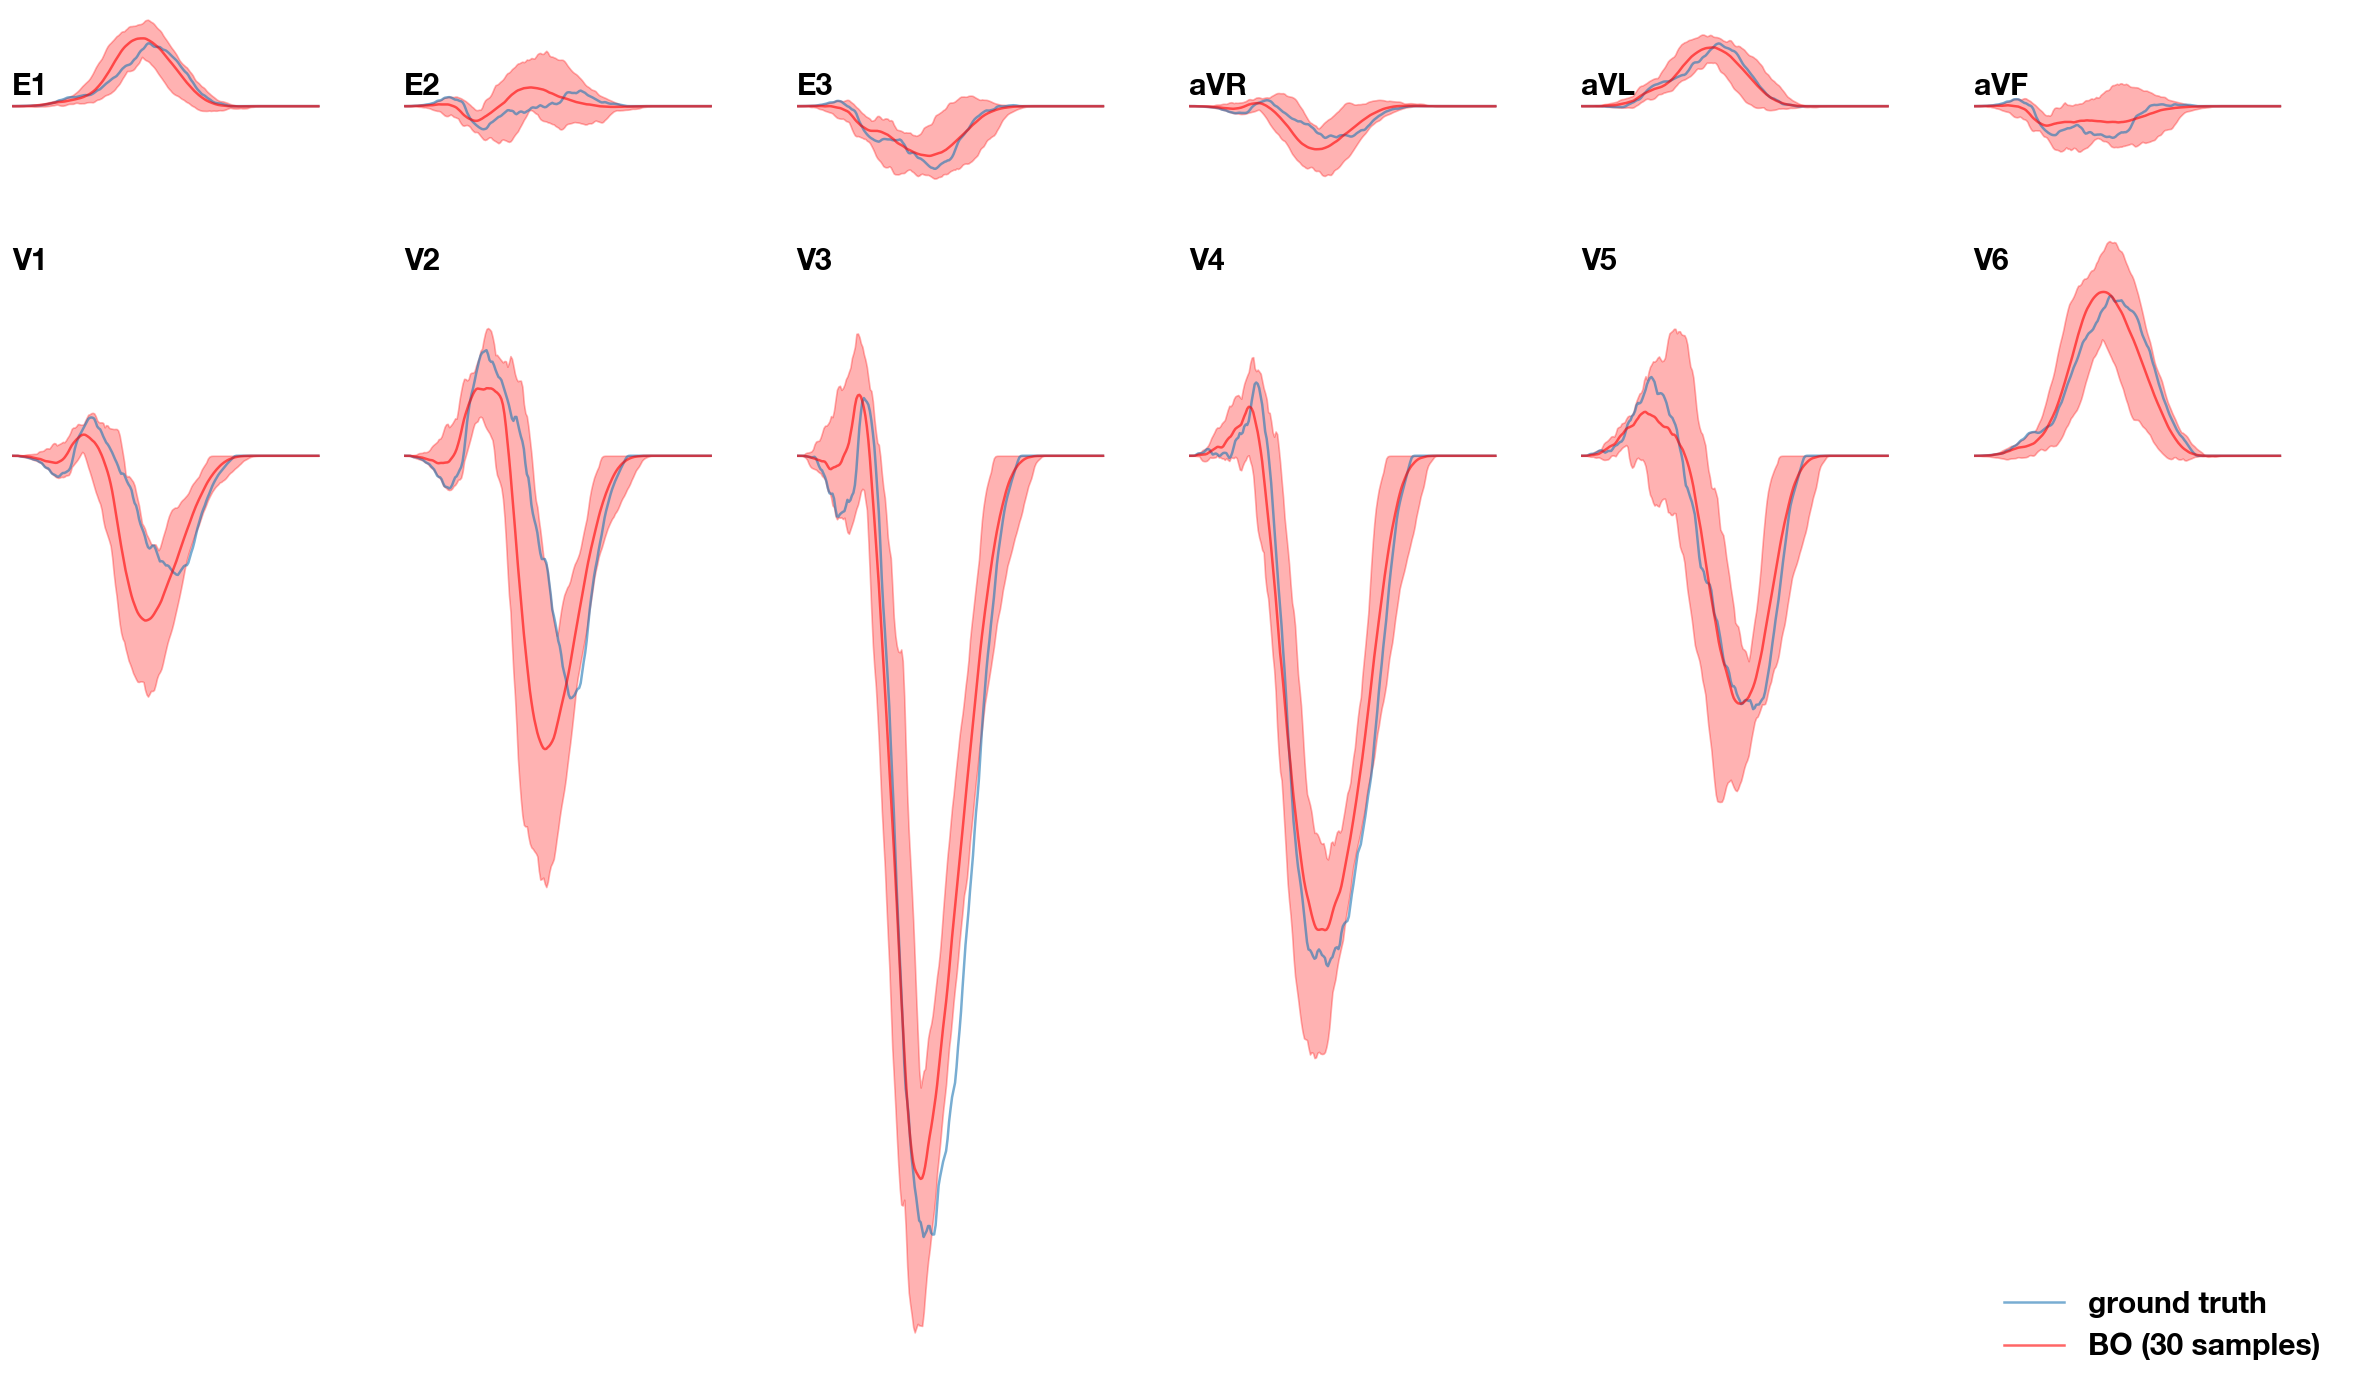

In [12]:
fig,axs = plt.subplots(2, 6,
                       figsize=(20,12), # 15, 9
                       dpi=120,
                       gridspec_kw={'height_ratios': heights},
                       sharex=True, sharey='row')

for ax,l in zip(axs.ravel(), ('E1', 'E2', 'E3', 'aVR', 'aVL', 'aVF','V1', 'V2', 'V3', 'V4', 'V5', 'V6' )): # bo_method.ground_truth.dtype.names
    ax.plot(ecg_true[l][0:250],'tab:blue', alpha=0.6, label="ground truth")
    
    n_sel  = len(selection_ecg)
    n_time = len(selection_ecg[0])
    
    ecg_l = onp.empty((n_sel, n_time))
    for ind in onp.arange(n_sel):
#         # plot all ecgs
#         ax.plot(selection_ecg[ind][l],'r', alpha=0.6)
        ecg_l[ind, :] = selection_ecg[ind][l]
    
    mean_l = np.mean(ecg_l, axis=0)
#     std_l  = np.std(ecg_l, axis=0)
    min_l  = np.min(ecg_l, axis=0)
    max_l  = np.max(ecg_l, axis=0)
        
    label_BO = "BO (" + str(n_candidates_selected) + " samples)"
    ax.plot(qrs_in + np.arange(len(mean_l)), mean_l,'r', alpha=0.6, label=label_BO)
    ax.fill_between(qrs_in + np.arange(len(min_l)), min_l, max_l, color='r', alpha=.3)

    #ax.grid(linestyle='--',alpha=0.4)
    ax.set_title(l, loc = 'left',y=1.0, pad = -50)
    ax.set_xlim((0,250))
    ax.set_axis_off()
    if l == "V6":
        ax.legend(fontsize="18", frameon = False, loc = 'lower right')
        
fig.tight_layout()
plt.subplots_adjust(hspace=0., wspace = 0.05)
fig.savefig(file_name+"_ecg_final.pdf")

#### Pairplot

In [13]:
# Create columns names for pairplot
df_columns = []
if "init_length" in var_parameters.keys():
    df_columns += [r"$l_{\rm i}^{\rm L}$ [mm]", r"$l_{\rm i}^{\rm R}$ [mm]"] # [r"In. Length L $l^{\rm L}$", "In. Length R"]
    
if "length" in var_parameters.keys():
    df_columns += ["Length"]
    
if "w" in var_parameters.keys():
    df_columns += ["w"]
    
if "fascicles_length" in var_parameters.keys():
    df_columns += [r"$l_{\rm F1}^{\rm L}$ [mm]", r"$l_{\rm F2}^{\rm L}$ [mm]", r"$l_{\rm F1}^{\rm R}$ [mm]", r"$l_{\rm F2}^{\rm R}$ [mm]"] 
    # ["Fas. Length L1", "Fas. Length L2", "Fas. Length R1", "Fas. Length R2"]
    
if "fascicles_angles" in var_parameters.keys():
    df_columns += [r"$\alpha_{\rm F1}^{\rm L}$ [º]", r"$\alpha_{\rm F2}^{\rm L}$ [º]", r"$\alpha_{\rm F1}^{\rm R}$ [º]", r"$\alpha_{\rm F2}^{\rm R}$ [º]"] 
    # ["Fas. Angle L1", "Fas. Angle L2", "Fas. Angle R1", "Fas. Angle R2"]
    
if "branch_angle" in var_parameters.keys():
    df_columns += ["Branch Angle"]
    
if "root_time" in var_parameters.keys():
    df_columns += ["RT [ms]"]
    
if "cv" in var_parameters.keys():
    df_columns += ["CV [m/s]"]

In [14]:
# Pairplot
X_final = samples_final
df      = pd.DataFrame(X_final, columns = df_columns)

In [15]:
def flatten_list(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, list):
            flat_list.extend(flatten_list(item))  # Recursively flatten nested lists
        else:
            flat_list.append(item)
    return flat_list

flat_true_x = flatten_list(true_x)

In [16]:
# Find boundaries
lb_params  = np.array([])
ub_params  = np.array([])

for var_name, var_value in var_parameters.items():
    lb_params = np.append(lb_params, var_value[0])
    ub_params = np.append(ub_params, var_value[1])
    
bounds = {'lb': lb_params, 'ub': ub_params}

In [17]:
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'cm'

def manual_pair_plot(data_frame):
    num_features = len(data_frame.columns)
    fig, axes    = plt.subplots(num_features, num_features, figsize = (25, 25), dpi = 120)#, sharex=True, sharey=True)
    
    for i, column1 in enumerate(data_frame.columns):
        for j, column2 in enumerate(data_frame.columns):
            ax = axes[i, j]
            ax.set_xlim((bounds["lb"][j], bounds["ub"][j]))
            
            # Remove top and right spines
            #ax.spines['top'].set_visible(False)
            #ax.spines['right'].set_visible(False)
            
            # Set the thickness of the remaining spines
            ax.spines['left'].set_linewidth(0.4)  # Adjust the linewidth as needed
            ax.spines['bottom'].set_linewidth(0.4)  # Adjust the linewidth as needed
            ax.spines['top'].set_linewidth(0.4)
            ax.spines['right'].set_linewidth(0.4)
            
            # Adjust the thickness of tick marks
            ax.tick_params(axis='both', which='both', width=0.4)  # Adjust the width as needed            

            if i == j:
                ax.hist(data_frame[column1],
                        range     = (bounds["lb"][j], bounds["ub"][j]),
                        bins      = 10,
                        color     = 'tab:red', # blue
                        alpha     = 0.8,
                        edgecolor = 'black',
                        linewidth = 0.4) # 'skyblue'
                
                # true values
                if flat_true_x[j] == bounds["lb"][j]:
                    x_range = bounds["ub"][j] - bounds["lb"][j]
                    ax.axvline(x = flat_true_x[j] + 0.02*x_range, color = 'tab:blue', linestyle = '--', alpha = 0.7, linewidth = 3.5) # red

                elif flat_true_x[j] == bounds["ub"][j]:
                    x_range = bounds["ub"][j] - bounds["lb"][j]
                    ax.axvline(x = flat_true_x[j] - 0.02*x_range, color = 'tab:blue', linestyle = '--', alpha = 0.7, linewidth = 3.5) # red

                else:
                    ax.axvline(x = flat_true_x[j], color = 'tab:blue', linestyle = '--', alpha = 0.7, linewidth = 3.5) # red
            
            elif i > j:
                ax.scatter(data_frame[column2],
                           data_frame[column1],
                           color = 'tab:red', # blue
                           s     = 8,
                           alpha = 0.7)
                # true values
#                 ax.axhline(y=flat_true_x[i], color='tab:red', linestyle='--', alpha=0.3)
                ax.scatter(flat_true_x[j], flat_true_x[i], color = 'tab:blue', s = 200, alpha = 1, marker = "*") # red
            
                ax.set_ylim((bounds["lb"][i], bounds["ub"][i]))
#                 ax.set_xlabel(column2)
#                 ax.set_ylabel(column1)
            
            else:
                fig.delaxes(ax)
            
            if i == num_features-1:
                if column2 == "Root time" or column2 == "CV":
                    ax.set_xlabel(column2, labelpad = -15)
                else:
                    ax.set_xlabel(column2, fontsize = 20, labelpad = -15)

                ax.set_xticks(ax.get_xlim())
                if "alpha" in column2:
                    ax.set_xticklabels(["%i" % (x*180/np.pi) for x in ax.get_xlim()])
                labels = ax.get_xticklabels()
                labels[0].set_horizontalalignment("left")
                labels[-1].set_horizontalalignment("right")
            else:
#                 ax.set_xticks([])
                ax.set_xticklabels([])
                
            if j == 0:
                if column1 == "Root time" or column1 == "CV":
                    ax.set_ylabel(column1, labelpad = -30)
                else:
                    ax.set_ylabel(column1, fontsize = 20, labelpad = -30)

                ax.set_yticks(ax.get_ylim())
                if "alpha" in column1:
                    ax.set_yticklabels(["%i" % (x*180/np.pi) for x in ax.get_ylim()])
                labels = ax.get_yticklabels()
                labels[0].set_verticalalignment("bottom")
                labels[-1].set_verticalalignment("top")
                
            else:
                ax.set_yticklabels([])    

    plt.tight_layout()
    fig.align_ylabels() # axs[:, 1]
    plt.subplots_adjust(wspace = 0.05, hspace = 0.05)#, left=0.2, right=0.9)

    assert (bounds["lb"][0] == bounds["lb"][1]) and (bounds["ub"][0] == bounds["ub"][1]),\
    "y labels of the first row copied from the second row"
    y_min_h, y_max_h = axes[0,0].get_ylim()
    y_min_d, y_max_d = axes[1,0].get_ylim()
    
    yticks_10  = axes[1,0].get_yticks()
    y_d        = yticks_10[onp.where((yticks_10 >= y_min_d) & (yticks_10 <= y_max_d))]
    int_y_d    = [int(element) for element in y_d]
    
    y_h = (y_d - y_min_d)/(y_max_d - y_min_d) * (y_max_h - y_min_h) + y_min_h
    
    # axes[0,0].set_yticks(y_h)
    # axes[0,0].set_yticklabels(int_y_d)
    axes[0,0].set_yticks([])


    # labels = axes[0,0].get_yticklabels()
    # labels[0].set_verticalalignment("bottom")
    # labels[-1].set_verticalalignment("top")
    #axes[0,0].set_yticklabels(int_y_d)

    plt.savefig(file_name+"_pairplot_new.pdf")
    plt.show()

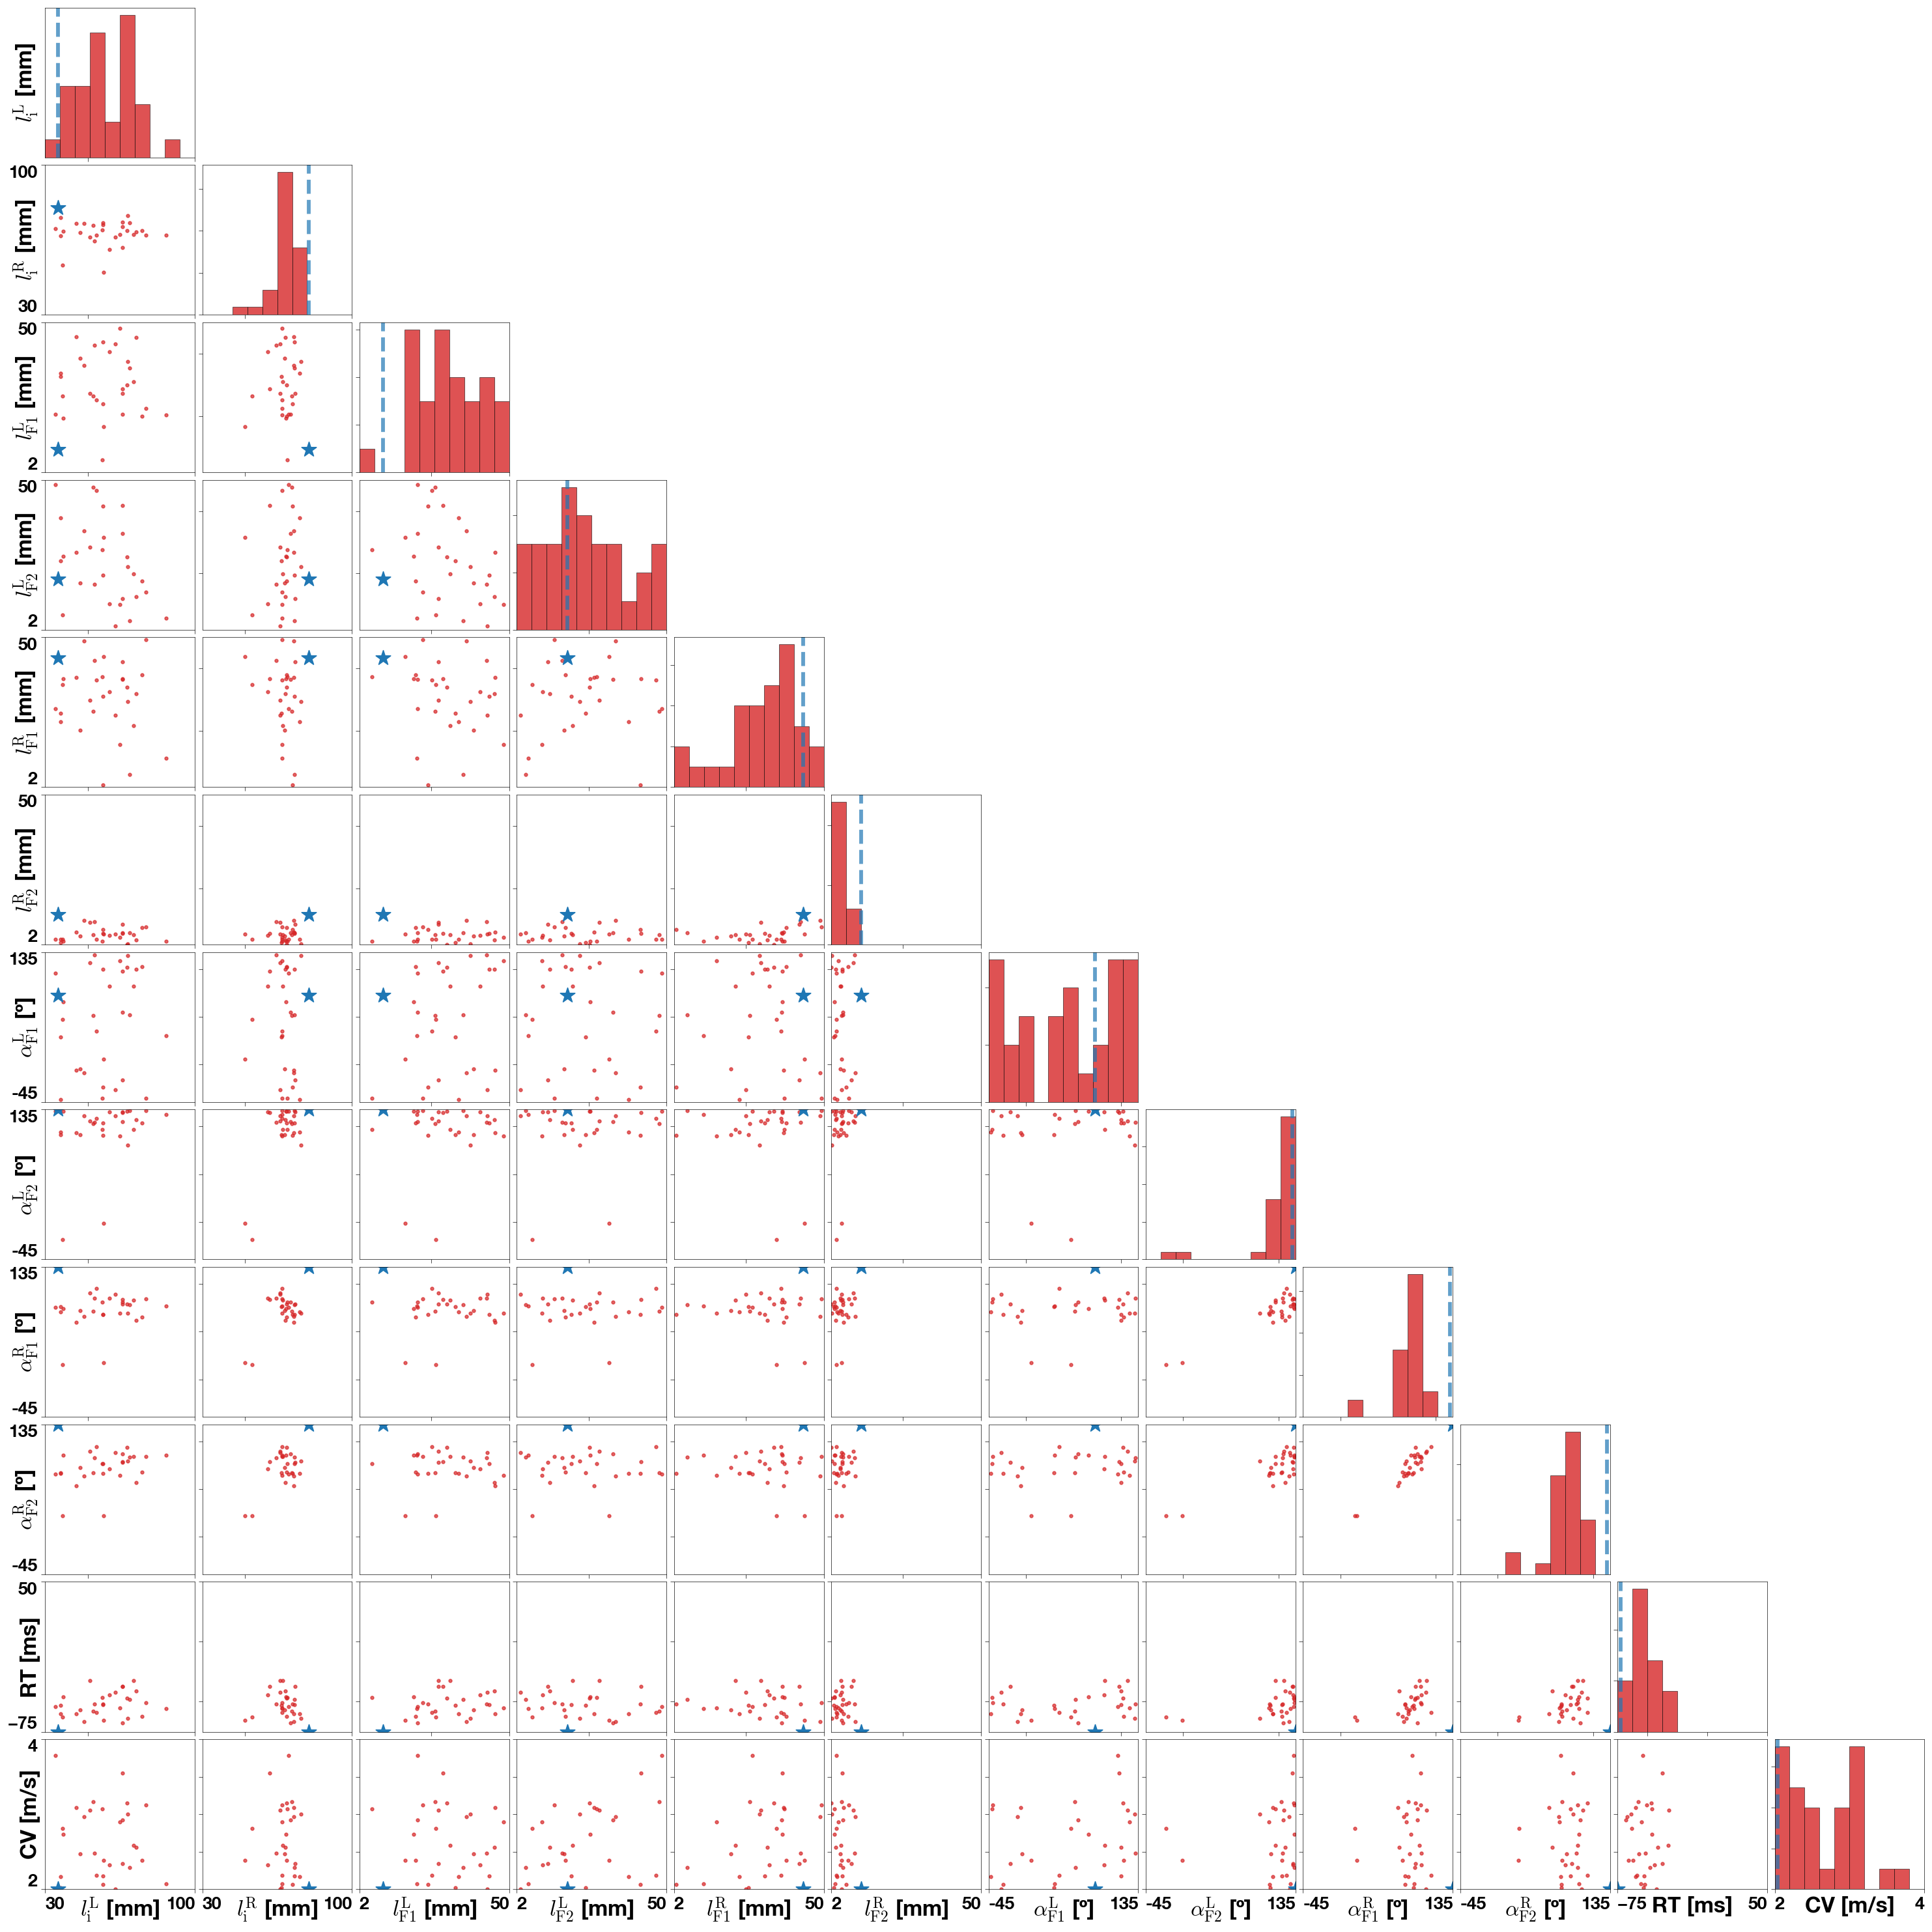

In [18]:
manual_pair_plot(df)

In [19]:
end_time = time.time()
print(f"Elapsed time: {end_time - start_time} s")

Elapsed time: 18.654000282287598 s
